<a href="https://colab.research.google.com/github/mirzaleiva2-cell/Clustering-assignment/blob/main/Project_3_Deep_%26_Wide_Nets%2C_RNNs%2C_Kernels_%26_Regressions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

How to run this notebook

In [ ]:
#Libraries that we used are
#pandas, np, seaborn, matplotlib, sklearn,torcj
#fixed random seed = 43
random_seed = 43

In [ ]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error

**1. Data Gathering & Description**

Data is collected from Kaggle via link:

https://www.kaggle.com/datasets/shree1992/housedata

Engineering challenges about this dataset is focused on its outliers in numerical and categorical columns. Both type of data have outliers. Rare categories in some columns are highly correlated with target label which is price. Therefore, removing rare categories from some of columns worsen the performance.

In [ ]:
df = pd.read_csv("data.csv")
print(df.head())

#We remove country, date and street and statezip
#country is just one value USA
#date is not important in our modeling
#street has many unique values, therefore we encode it, the features set become pretty sparse and big
#we removed statezip also,as we found it has many unique values same as street
df = df.drop(["country","street","statezip"],axis=1)

                  date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0  2014-05-02 00:00:00   313000.0       3.0       1.50         1340      7912   
1  2014-05-02 00:00:00  2384000.0       5.0       2.50         3650      9050   
2  2014-05-02 00:00:00   342000.0       3.0       2.00         1930     11947   
3  2014-05-02 00:00:00   420000.0       3.0       2.25         2000      8030   
4  2014-05-02 00:00:00   550000.0       4.0       2.50         1940     10500   

   floors  waterfront  view  condition  sqft_above  sqft_basement  yr_built  \
0     1.5           0     0          3        1340              0      1955   
1     2.0           0     4          5        3370            280      1921   
2     1.0           0     0          4        1930              0      1966   
3     1.0           0     0          4        1000           1000      1963   
4     1.0           0     0          4        1140            800      1976   

   yr_renovated                    str

**EDA**

In [ ]:
#Checking for NaN values (missing values)

print("NaN values per column:")
display(df.isna().sum())

NaN values per column:


date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
city             0
dtype: int64

We can see that we don't have any missing values

In [ ]:
# Basic describe with styled output
#Basic description of our dataframe
desc = df.describe().T.style.background_gradient(cmap="Blues") \
                               .set_table_styles([{"selector": "th",
                                                   "props": [("font-size", "12pt"),
                                                             ("text-align", "center")]}]) \
                               .set_caption("📊 Descriptive Statistics of Numerical Features")

desc


,count,mean,std,min,25%,50%,75%,max
price,4600.000000,551962.988473,563834.702547,0.000000,322875.000000,460943.461539,654962.500000,26590000.000000
bedrooms,4600.000000,3.400870,0.908848,0.000000,3.000000,3.000000,4.000000,9.000000
bathrooms,4600.000000,2.160815,0.783781,0.000000,1.750000,2.250000,2.500000,8.000000
sqft_living,4600.000000,2139.346957,963.206916,370.000000,1460.000000,1980.000000,2620.000000,13540.000000
sqft_lot,4600.000000,14852.516087,35884.436145,638.000000,5000.750000,7683.000000,11001.250000,1074218.000000
floors,4600.000000,1.512065,0.538288,1.000000,1.000000,1.500000,2.000000,3.500000
waterfront,4600.000000,0.007174,0.084404,0.000000,0.000000,0.000000,0.000000,1.000000
view,4600.000000,0.240652,0.778405,0.000000,0.000000,0.000000,0.000000,4.000000
condition,4600.000000,3.451739,0.677230,1.000000,3.000000,3.000000,4.000000,5.000000
sqft_above,4600.000000,1827.265435,862.168977,370.000000,1190.000000,1590.000000,2300.000000,9410.000000


We can see statistical feature of each column in plot above.

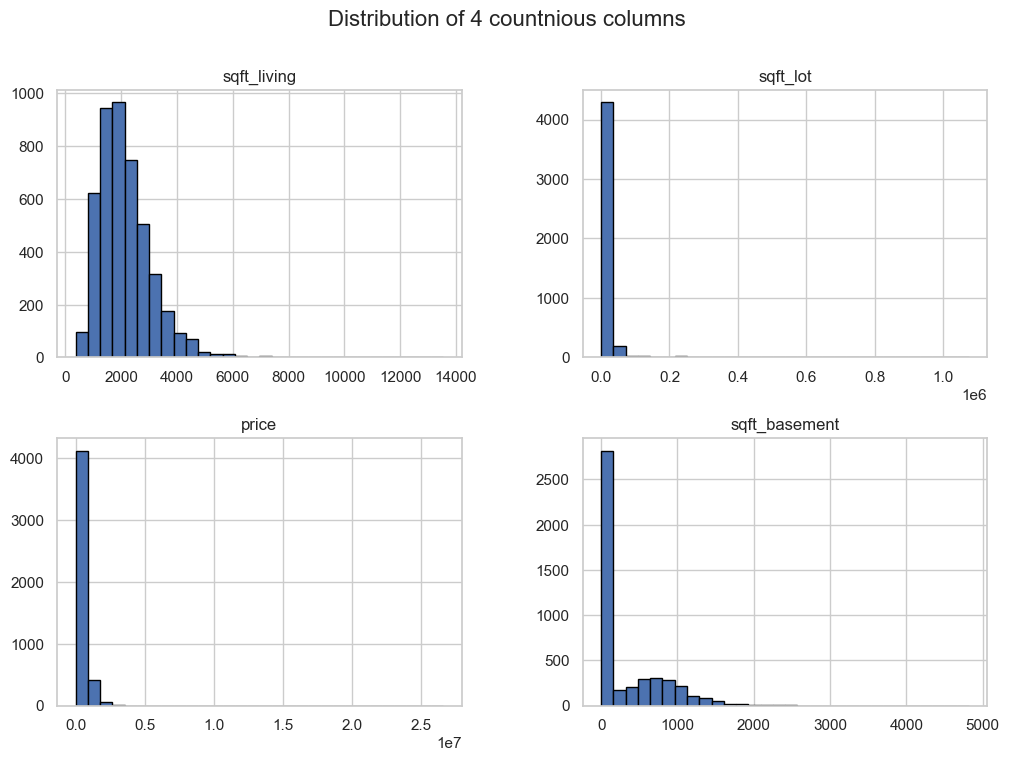

In [ ]:
#Plotting the distributions of "sqft_living","sqft_lot","price","sqft_basement"
# List of numerical columns
cols = ["sqft_living","sqft_lot","price","sqft_basement"]

# Set style
sns.set(style="whitegrid")

# Plot histograms for each numerical column
df[cols].hist(figsize=(12, 8), bins=30, edgecolor="black")
plt.suptitle("Distribution of 4 countnious columns", fontsize=16)
plt.show()


The plot above demonstrate distribution for sqft_living,sqft_basement,price and sqft_lot columns.

Next plot demonstrate outliers using boxplot.

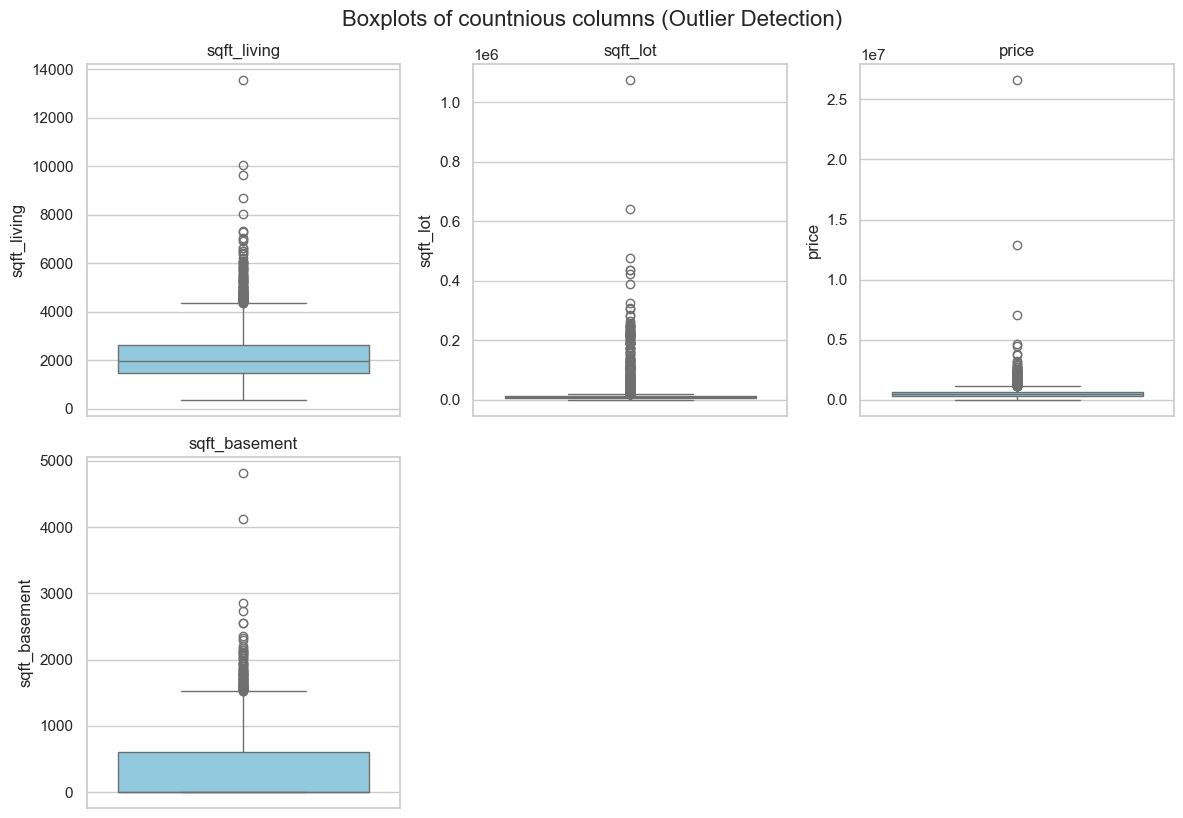

In [ ]:
plt.figure(figsize=(12, 8))

for i, col in enumerate(cols, 1):
    plt.subplot(2, 3, i)  # 2 rows, 3 columns layout
    sns.boxplot(y=df[col], color="skyblue")
    plt.title(col)

plt.tight_layout()
plt.suptitle("Boxplots of countnious columns (Outlier Detection)", fontsize=16, y=1.02)
plt.show()


The boxplots demonstrate the outlier of these numerical values.

- **sqft_living** and **sqft_basement** show a cluster of extreme values on the higher end, indicating unusually large houses or basements.  
- **sqft_lot** has several very large values, suggesting the presence of properties with exceptionally large land sizes.  
- **price** also shows extreme outliers, which may correspond to luxury houses significantly more expensive than the majority of properties.

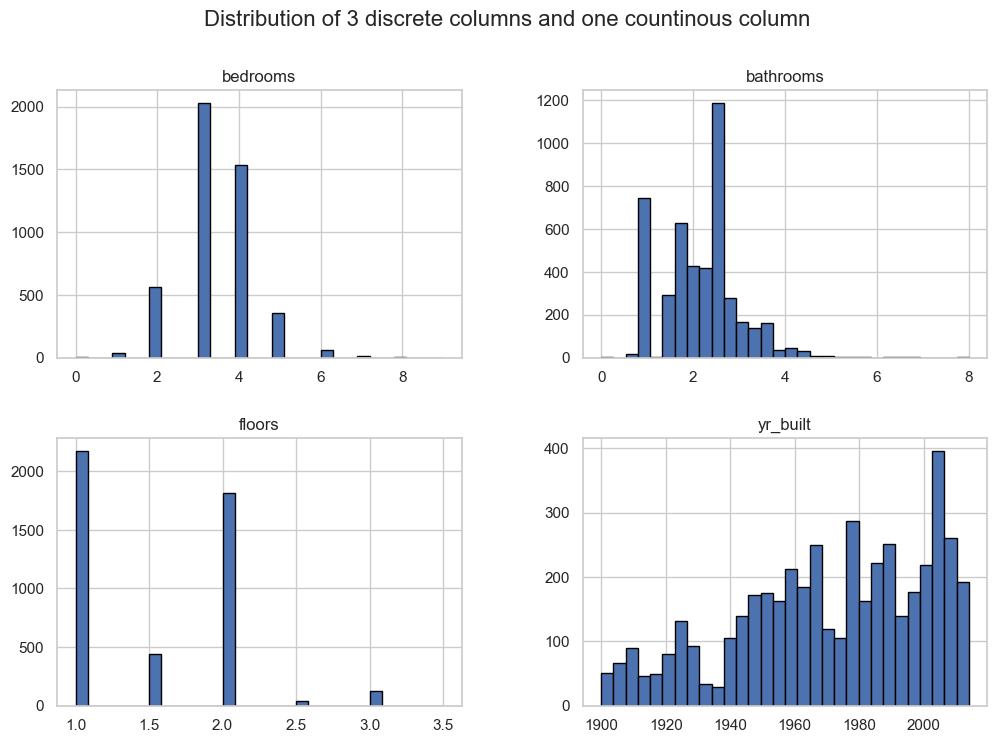

In [ ]:
#Plotting the distributions of "bedrooms","bathrooms","floors","yr_built"
#Discrete columns
cols = ["bedrooms","bathrooms","floors","yr_built"]

# Set style
sns.set(style="whitegrid")

# Plot histograms for each numerical column
df[cols].hist(figsize=(12, 8), bins=30, edgecolor="black")
plt.suptitle("Distribution of 3 discrete columns and one countinous column", fontsize=16)
plt.show()


This plot demonstrates the distributions of three discrete columns: floors,bedrooms,bathrooms and countinous yr_built.

/var/folders/8w/09vt15ls6pzgs8rtbnl55l7m0000gn/T/ipykernel_18742/977934541.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="city", order=df["city"].value_counts().index, palette="viridis")


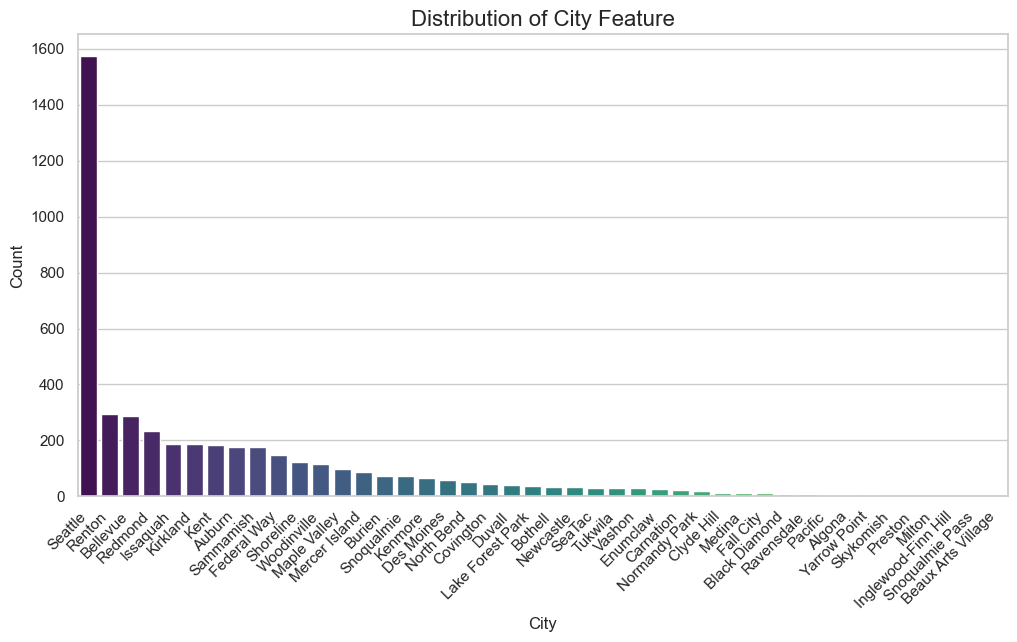

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(data=df, x="city", order=df["city"].value_counts().index, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Distribution of City Feature", fontsize=16)
plt.xlabel("City")
plt.ylabel("Count")
plt.show()


This plot demonstrates the count of each record in each city.

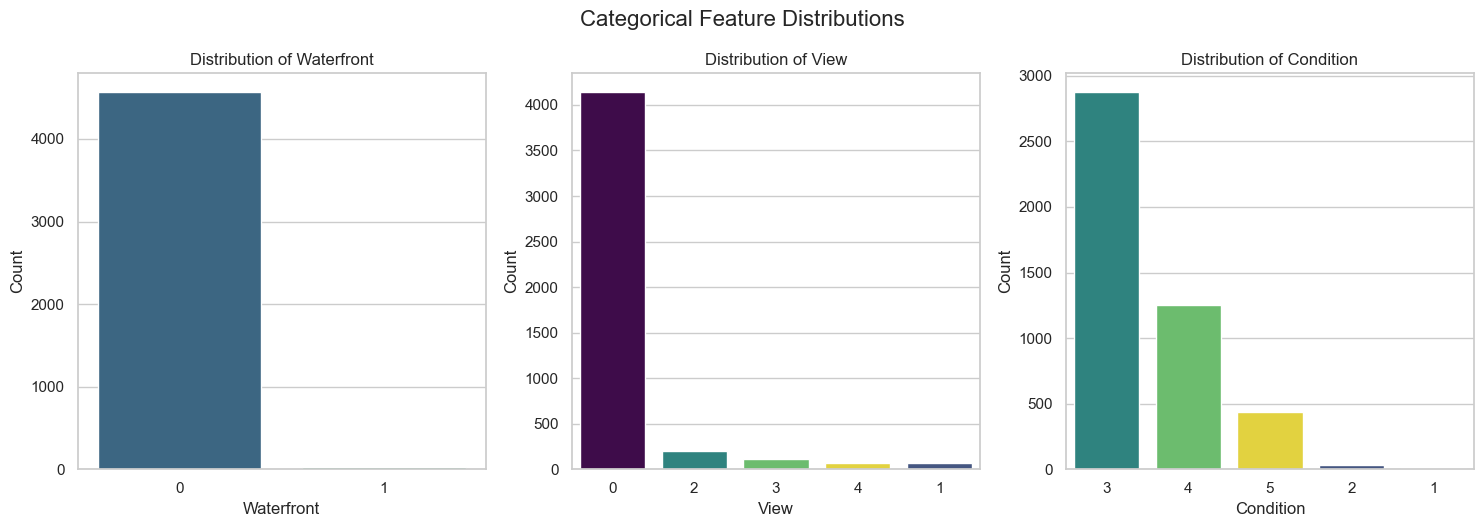

In [ ]:
categorical_cols = ["waterfront", "view", "condition"]

plt.figure(figsize=(15, 5))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(1, 3, i)
    sns.countplot(data=df, x=col, hue=col, palette="viridis", order=df[col].value_counts().index, legend=False)
    plt.title(f"Distribution of {col.capitalize()}")
    plt.xlabel(col.capitalize())
    plt.ylabel("Count")

plt.tight_layout()
plt.suptitle("Categorical Feature Distributions", fontsize=16, y=1.05)
plt.show()


We can see the Waterfront feature is pretty imbalanced, therefore we can remove it.

Also, for the view, it is pretty imbalanced between 0 and 2,3,4,1 values.

Distribution of Condition is fine, although we have absolutely a few records with condition value of 1.

**Removing Outliers**

In [ ]:
#This function remove any outliers using IQR
#Only for numerical values
def remove_outliers_iqr(df, columns, k=1.5):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - k * IQR
        upper = Q3 + k * IQR

        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]

    return df_clean

#Selected cols to be checked for IQR
numerical_cols = ["sqft_living","sqft_lot","sqft_basement"]
df = remove_outliers_iqr(df, numerical_cols)

print(f"After outlier removal: {df.shape}")

After outlier removal: (3929, 15)


We dropped any values of our selected numerical values which are out of the quantiles with K=1.5

Now we drop categories with rare frequencies.

We did not remove outliers from our target label which is "price".

In [ ]:
# #Now we remove the outliers from categorical columns
# print(df["condition"].value_counts(normalize=True)) #For condition
# #We drop condition with values of 1 and 2, as they are
# df = df[~df["condition"].isin([1, 2])]

# #For view we have
# print(df["view"].value_counts(normalize=True)) #For View
# #We transform view to be have only two values
# df["view"] = np.where(df["view"] == 0,0,1)



We did not remove the rare categories as they are highly correlated with out target label. Because we tested the models with above transform, and without above transform. With that transform, our models' MSE was very high around 4.5, and without that transform, the model's MSE is around 0.1

In [ ]:
#Finaly we have for view
print(df["view"].value_counts(normalize=True)) #For View

0    0.920336
2    0.039196
3    0.017562
1    0.013998
4    0.008908
Name: view, dtype: float64


We removed rare categories from "condition" and also we transformed "view" to be in binary mode.

What was the single hardest bug or training issue you faced here (include error messages or plots)?

- Showing the distribution plots and box plots were the hardest parts because, no mather how scaling is,still showing all the values is almost impossible.

What new insight did you gain about model behavior that no black-box solution could teach you?

- Not build the model yet. However, handling the outliers was the most important part of this section. Outliers in categorical columns shows us how important is some of the rare values such as "condition" and "view" columns.

**2. Feature Engineering & Date Preprocessing (scaling and encoding)**

In [ ]:
#Features creation
df["total_rooms"] = df["bedrooms"] + df["bathrooms"]   #First feature
df["is_renovated"] = np.where(df["yr_renovated"] == 0,0,1)   #Second feature
df["house_age"] = 2025 - df["yr_built"]   #Third feature



**total_rooms**, basically is the sum of all bedrooms and bathroom together.

**is_renovated**, because many of the rows has 0 as value for renovated year, I create a new feature which is , if the house has been renovated or not

**house_age**, is the difference between 2025 as current age and the year the house has been built


In [ ]:
#We also remove one feature from our dataframe
#Also we remove bedrooms, bathrooms,yr_renovated and yr_built
#As I created the features above, I remove these ones, because they are correlated with each other
df.drop(["bedrooms","bathrooms","yr_renovated","waterfront"],axis=1,inplace=True)


In [ ]:
#Numerical columns & Ordinal columns
numerical_cols = ["sqft_living","sqft_lot","floors","sqft_basement","house_age","total_rooms"]   #Features to be scaled
ordinal_cols = ["view","condition"]  #We don't scale these features

X = df.drop("price",axis=1)   #Features
Y = df["price"]    #Target label


In [ ]:
#Train and test split with fixed random state of 43
df_train_features, df_test_features, df_train_target,df_test_target = train_test_split(X,Y,random_state=random_seed,test_size=0.3)

In [ ]:
#Scaling our features
categorical_encoder = OneHotEncoder(sparse_output=False,handle_unknown="infrequent_if_exist")
numerical_scaler = StandardScaler()
target_scaler = StandardScaler()

encoded_features_train = categorical_encoder.fit_transform(df_train_features["city"].values.reshape(-1,1))
scaled_features_train = numerical_scaler.fit_transform(df_train_features[numerical_cols])


encoded_features_test = categorical_encoder.transform(df_test_features["city"].values.reshape(-1,1))
scaled_features_test = numerical_scaler.transform(df_test_features[numerical_cols])

ordinal_features_train = df_train_features[ordinal_cols].values
ordinal_features_test = df_test_features[ordinal_cols].values

#Scaling our target labeles
trainY = target_scaler.fit_transform(df_train_target.values.reshape(-1,1))
testY = target_scaler.transform(df_test_target.values.reshape(-1,1))


#Concatenating our features set from encoded categorical and scaled numerical data
trainX = np.hstack([encoded_features_train,scaled_features_train,ordinal_features_train])
testX = np.hstack([encoded_features_test,scaled_features_test,ordinal_features_test])


In [ ]:
print("Shape of our training set: " ,trainX.shape)
print("Shape of our test set: " ,testX.shape)

Shape of our training set:  (2750, 51)
Shape of our test set:  (1179, 51)


What was the single hardest bug or training issue you faced here (include error messages or plots)?

- Encoding categorical columns was single hardest bug. Because as we split the dataset into the training and test sets, some values in citiy column are not available in both sets. therefore we had to use "infrequest_if_exist" method to handle unknown values.

What new insight did you gain about model behavior that no black-box solution could teach you?

- Not build the model yet. However, feature engineering could tell us how our features can be important to be used in machine learning algorithms or neural networks. Also, scaling the numerical features helped model development a lot.

**3.Baseline Regression & Kernel method**

,Model,Params,Time,MSE
24,KernelRidge-Poly,"alpha=1, degree=2",0.195382,0.094305
25,KernelRidge-Poly,"alpha=1, degree=3",0.270185,0.094741
6,KernelRidge-RBF,"alpha=0.01, gamma=0.001",0.263026,0.095915
11,KernelRidge-RBF,"alpha=0.1, gamma=0.01",0.311305,0.096187
4,Ridge,alpha=10,0.000844,0.097709
26,KernelRidge-Poly,"alpha=1, degree=4",0.297487,0.097782
15,KernelRidge-RBF,"alpha=1, gamma=0.01",0.335694,0.098270
10,KernelRidge-RBF,"alpha=0.1, gamma=0.001",0.303242,0.098660
21,KernelRidge-Poly,"alpha=0.1, degree=2",0.183066,0.098813
31,ElasticNet,"alpha=0.01, l1_ratio=0.2",0.005085,0.100364


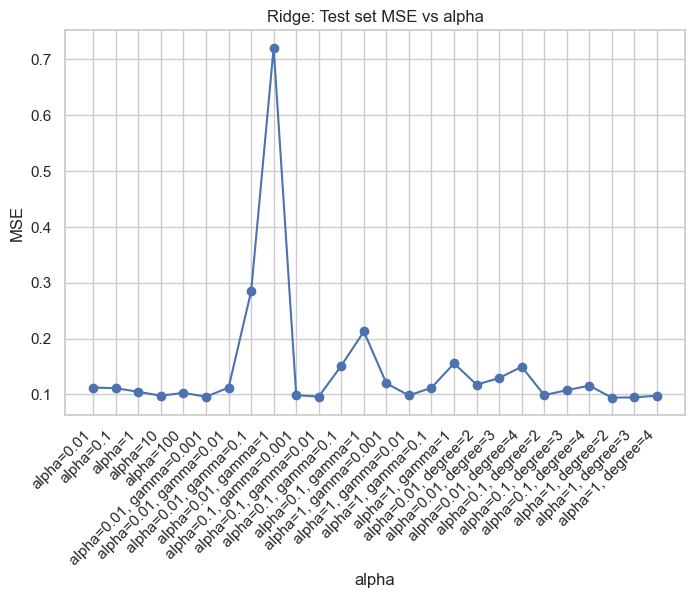

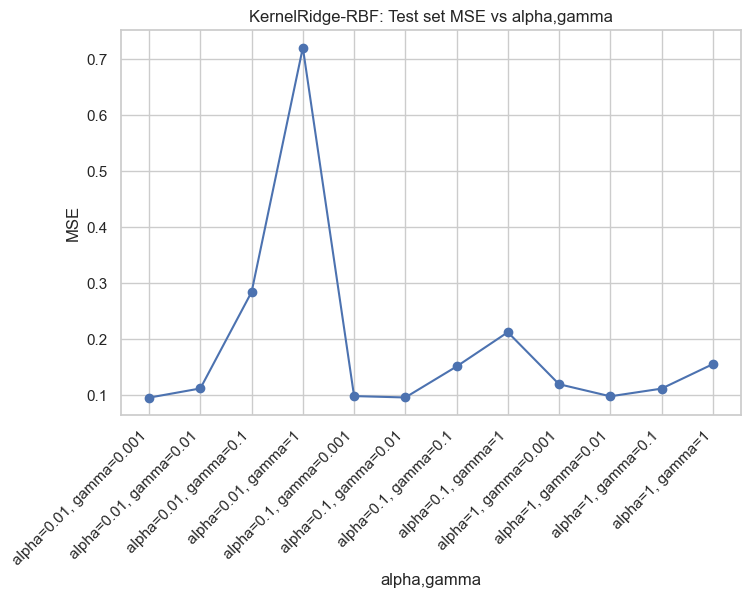

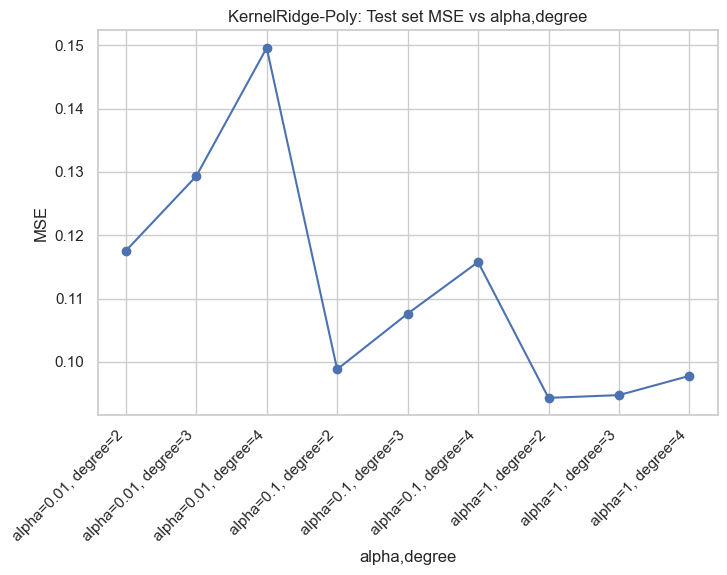

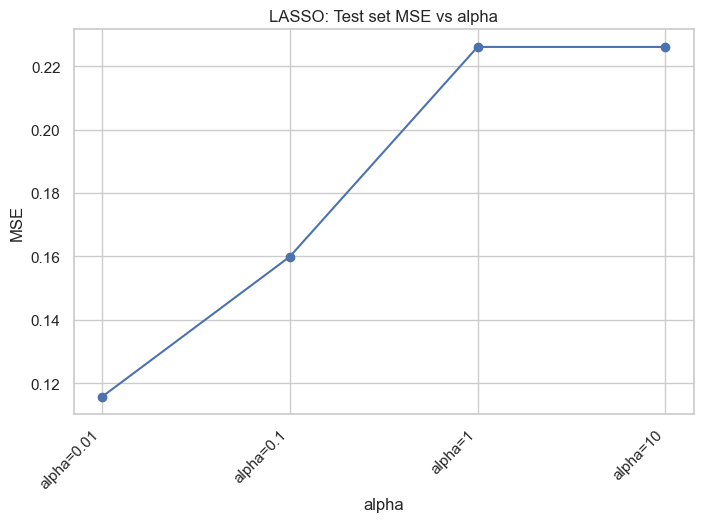

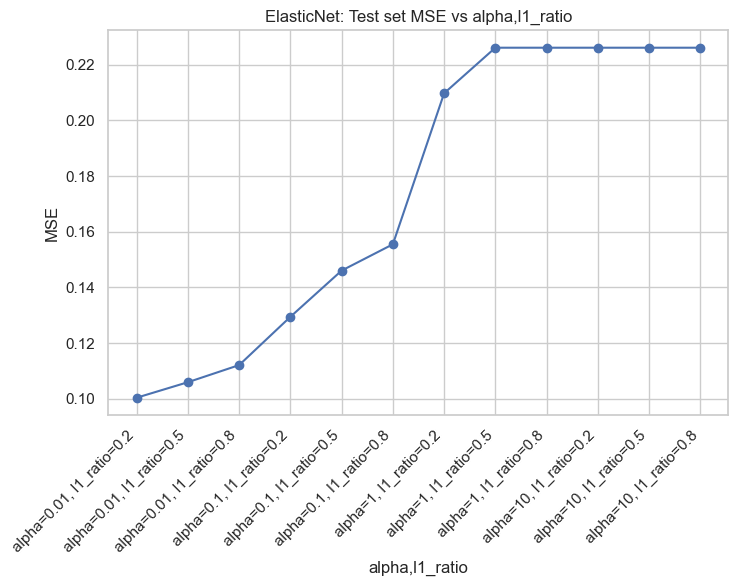

In [ ]:
# Helper function to evaluate models with timing + MSE
def evaluate_model(model, trainX, trainY, testX, testY):
    start = time.time()
    model.fit(trainX, trainY)
    elapsed = time.time() - start

    preds = model.predict(testX)
    mse = mean_squared_error(testY, preds)
    return elapsed, mse,preds

# Store results
results = []


# 1. OLS and Ridge Regression
ols = LinearRegression()
elapsed, mse,preds = evaluate_model(ols, trainX, trainY, testX, testY)
results.append({"Model": "OLS", "Params": "N/A", "Time": elapsed, "MSE": mse,"preds":preds})


alphas = [0.01, 0.1, 1, 10, 100]
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    elapsed, mse,preds = evaluate_model(ridge, trainX, trainY, testX, testY)
    results.append({"Model": "Ridge", "Params": f"alpha={alpha}", "Time": elapsed, "MSE": mse,"preds":preds})


# 2. Kernel Ridge Regression (RBF + Polynomial kernels)
alphas = [0.01, 0.1, 1]
gammas = [0.001, 0.01, 0.1, 1]
degrees = [2, 3, 4]

# RBF kernel
for alpha in alphas:
    for gamma in gammas:
        kr_rbf = KernelRidge(kernel="rbf", alpha=alpha, gamma=gamma)
        elapsed, mse,preds = evaluate_model(kr_rbf, trainX, trainY, testX, testY)
        results.append({"Model": "KernelRidge-RBF",
                        "Params": f"alpha={alpha}, gamma={gamma}",
                        "Time": elapsed, "MSE": mse,"preds":preds})

# Polynomial kernel
for alpha in alphas:
    for degree in degrees:
        kr_poly = KernelRidge(kernel="polynomial", alpha=alpha, degree=degree)
        elapsed, mse,preds = evaluate_model(kr_poly, trainX, trainY, testX, testY)
        results.append({"Model": "KernelRidge-Poly",
                        "Params": f"alpha={alpha}, degree={degree}",
                        "Time": elapsed, "MSE": mse,"preds":preds})


# 3. LASSO and ElasticNet
alphas = [0.01, 0.1, 1, 10]
l1_ratios = [0.2, 0.5, 0.8]

# LASSO
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    elapsed, mse,preds = evaluate_model(lasso, trainX, trainY, testX, testY)
    results.append({"Model": "LASSO", "Params": f"alpha={alpha}", "Time": elapsed, "MSE": mse,"preds":preds})

# ElasticNet
for alpha in alphas:
    for l1 in l1_ratios:
        enet = ElasticNet(alpha=alpha, l1_ratio=l1, max_iter=10000)
        elapsed, mse,preds = evaluate_model(enet, trainX, trainY, testX, testY)
        results.append({"Model": "ElasticNet",
                        "Params": f"alpha={alpha}, l1_ratio={l1}",
                        "Time": elapsed, "MSE": mse,"preds":preds})


# Results as DataFrame

results_df = pd.DataFrame(results)
#results_df.drop("preds",axis=1,inplace=True)
display(results_df.drop("preds",axis=1).sort_values("MSE"))


# 4. Plot errors vs parameters

def plot_results(df, model_name, param_name):
    subset = df[df["Model"].str.contains(model_name)]
    if not subset.empty:
        plt.figure(figsize=(8,5))
        plt.plot(subset["Params"], subset["MSE"], marker="o")
        plt.title(f"{model_name}: Test set MSE vs {param_name}")
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("MSE")
        plt.xlabel(param_name)
        plt.grid(True)
        plt.show()

plot_results(results_df, "Ridge", "alpha")
plot_results(results_df, "KernelRidge-RBF", "alpha,gamma")
plot_results(results_df, "KernelRidge-Poly", "alpha,degree")
plot_results(results_df, "LASSO", "alpha")
plot_results(results_df, "ElasticNet", "alpha,l1_ratio")


The best model among all of these models is :

KernelRidge-Poly	alpha=1, degree=2	total time 0.218299   with MSE of 0.094305


What was the single hardest bug or training issue you faced here (include error messages or plots)?

- Maitaing and evaluating each model was the hardest issue. Because, we had to store all the results such as time and MSE metric with model and it's parameters to show it later and also to use it later for plotting error-distribution histogram.

What new insight did you gain about model behavior that no black-box solution could teach you?

- We learnt that parameters for each model can be pretty much imporant factor on both model performance and model speed convergence. Also, it shows us how non-linear kernels performs better than linear ones.

**4. Feedforward Neural Networks in PyTorch**

Creating Torch Tensor from our dataset

And finally, creating Tensor Datasets and Data Loaders for training and evaluating our models.

In [ ]:
# Convert to PyTorch tensors
X_train = torch.tensor(trainX, dtype=torch.float32)
X_test = torch.tensor(testX, dtype=torch.float32)
y_train = torch.tensor(trainY, dtype=torch.float32)
y_test = torch.tensor(testY, dtype=torch.float32)

# Create DataLoader for training and test sets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Defining each neural network

In [ ]:
# ======================================
# Custom activation (Swish)
# ======================================
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# ======================================
# Model Architectures
# ======================================
class ShallowNet(nn.Module):
    def __init__(self, input_dim, output_dim, enhanced=False):
        super().__init__()
        self.enhanced = enhanced
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, output_dim)

        if enhanced:
            self.bn1 = nn.BatchNorm1d(64)
            self.act = Swish()
            self.drop = nn.Dropout(0.3)
        else:
            self.act = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        if self.enhanced:
            x = self.bn1(x)
        x = self.act(x)
        if self.enhanced:
            x = self.drop(x)
        x = self.fc2(x)
        return x


class DeepNet(nn.Module):
    def __init__(self, input_dim, output_dim, enhanced=False):
        super().__init__()
        self.enhanced = enhanced
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, output_dim)

        if enhanced:
            self.bn1, self.bn2, self.bn3, self.bn4 = (
                nn.BatchNorm1d(128),
                nn.BatchNorm1d(128),
                nn.BatchNorm1d(64),
                nn.BatchNorm1d(32),
            )
            self.act = Swish()
            self.drop = nn.Dropout(0.3)
        else:
            self.act = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        if self.enhanced: x = self.bn1(x)
        x = self.act(x)
        if self.enhanced: x = self.drop(x)

        x = self.fc2(x)
        if self.enhanced: x = self.bn2(x)
        x = self.act(x)
        if self.enhanced: x = self.drop(x)

        x = self.fc3(x)
        if self.enhanced: x = self.bn3(x)
        x = self.act(x)
        if self.enhanced: x = self.drop(x)

        x = self.fc4(x)
        if self.enhanced: x = self.bn4(x)
        x = self.act(x)
        if self.enhanced: x = self.drop(x)

        x = self.fc5(x)
        return x


class WideNet(nn.Module):
    def __init__(self, input_dim, output_dim, enhanced=False):
        super().__init__()
        self.enhanced = enhanced
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, output_dim)

        if enhanced:
            self.bn1 = nn.BatchNorm1d(512)
            self.act = Swish()
            self.drop = nn.Dropout(0.4)
        else:
            self.act = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        if self.enhanced: x = self.bn1(x)
        x = self.act(x)
        if self.enhanced: x = self.drop(x)
        x = self.fc2(x)
        return x




We defind several NN architectures as has been asked. Each has a parameter enhanced, which by default is False. This parameter tell the model to be enhanced version or baseline.

In [ ]:
#Training function
#This function train the model with default epochs of 50 and learning rate of 1e-3
def train_model(model, train_loader, val_loader, epochs=50, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X, y in train_loader:
            optimizer.zero_grad()
            preds = model(X)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X.size(0)
        train_losses.append(running_loss / len(train_loader.dataset))

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X, y in val_loader:
                preds = model(X)
                loss = criterion(preds, y)
                val_loss += loss.item() * X.size(0)
        val_losses.append(val_loss / len(val_loader.dataset))

    return train_losses, val_losses

#Run experiments

#this function run the experiment for all NNs
def run_experiments(train_loader, val_loader, input_dim, output_dim):
    models = {
        "Shallow-Baseline": ShallowNet(input_dim, output_dim, enhanced=False),
        "Shallow-Enhanced": ShallowNet(input_dim, output_dim, enhanced=True),
        "Deep-Baseline": DeepNet(input_dim, output_dim, enhanced=False),
        "Deep-Enhanced": DeepNet(input_dim, output_dim, enhanced=True),
        "Wide-Baseline": WideNet(input_dim, output_dim, enhanced=False),
        "Wide-Enhanced": WideNet(input_dim, output_dim, enhanced=True),
    }

    results = {}
    results2 = []
    trained_models = []
    for name, model in models.items():
        t1 = time.time()
        print(f"Training {name}...")
        train_losses, val_losses = train_model(model, train_loader, val_loader)
        results[name] = (train_losses, val_losses)
        # Plot curves
        plt.figure()
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses, label="Test Loss")
        plt.title(f"{name} Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("MSE Loss")
        plt.legend()
        plt.show()
        t2 = time.time()
        print(f"Total time for {name} is {t2-t1} seconds")
        print(f"{name} Final Test MSE: {val_losses[-1]:.4f}\n")

        new_res = {"Model": name,  "Time": t2-t1, "MSE": val_losses[-1]}
        results2.append(new_res)
        trained_models.append({"Model":name,"model_obj":model})
    return results,results2,trained_models


In above cell, we defiend two functions: train_model and run_experiments

*train_model* does training the model with Adam as optimizer with learning_rate of 1e-3 and with MSE Loss.

*run_experiments* does train the model,evaluate the model and append the result to a dictionary. Plus it also visualize the model training and test loss.


Training Shallow-Baseline...


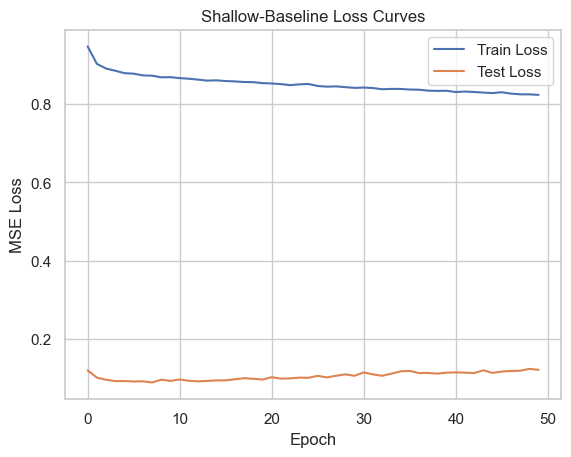

Total time for Shallow-Baseline is 2.4013240337371826 seconds
Shallow-Baseline Final Test MSE: 0.1203

Training Shallow-Enhanced...


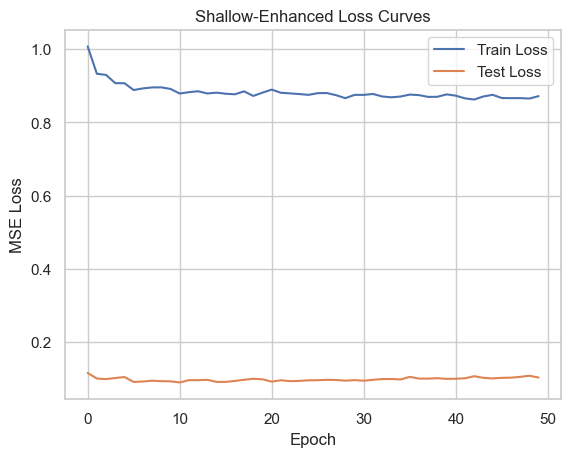

Total time for Shallow-Enhanced is 2.237745761871338 seconds
Shallow-Enhanced Final Test MSE: 0.1025

Training Deep-Baseline...


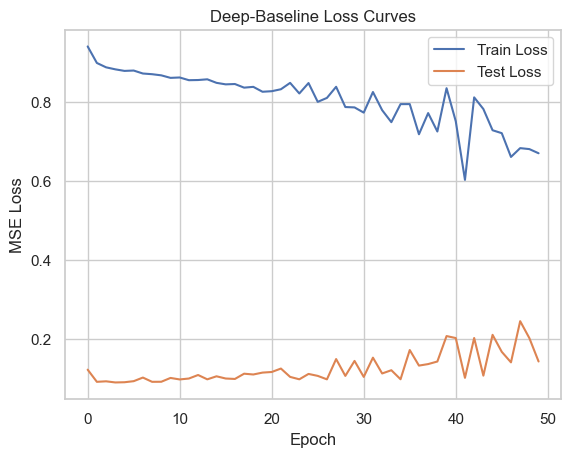

Total time for Deep-Baseline is 3.1157407760620117 seconds
Deep-Baseline Final Test MSE: 0.1434

Training Deep-Enhanced...


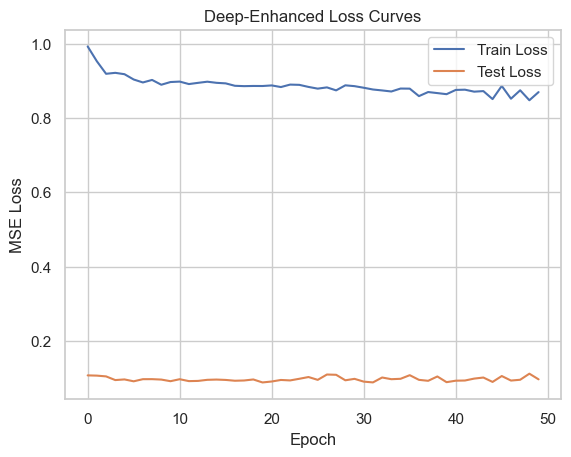

Total time for Deep-Enhanced is 5.6519927978515625 seconds
Deep-Enhanced Final Test MSE: 0.0967

Training Wide-Baseline...


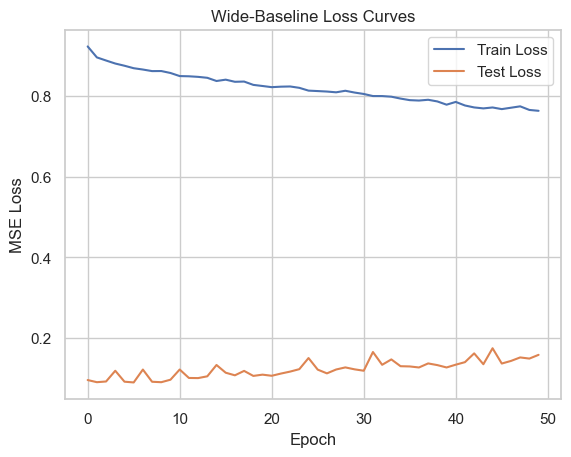

Total time for Wide-Baseline is 3.162363052368164 seconds
Wide-Baseline Final Test MSE: 0.1586

Training Wide-Enhanced...


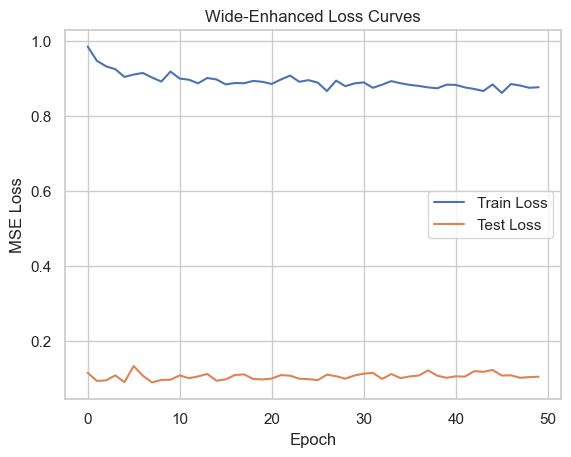

Total time for Wide-Enhanced is 5.123841047286987 seconds
Wide-Enhanced Final Test MSE: 0.1053



In [ ]:
#Finally this here, we run all the experiments with different NN architectures
nn_results,nn_results_total,nn_trained_models = run_experiments(train_loader,test_loader,input_dim=X_train.shape[1],output_dim=1)

What was the single hardest bug or training issue you faced here (include error messages or plots)?

- Training and evaluating each model with different parameters and storing the results was the hardest issue here. Also, storing the training and validation loss seperately for plotting later added an extra layer of issue.

What new insight did you gain about model behavior that no black-box solution could teach you?

- Well, we saw how baseline and enhanced architecture for each model type can change the model training loss and it's performance dramatically. Deep model shows the best performance.

**5. Recurrent Neural Network Extension**

In [ ]:
def create_windows(X, y, window_size=10):
    X, y = np.array(X), np.array(y)
    X_win, y_win = [], []

    for i in range(len(X) - window_size):
        X_win.append(X[i:i+window_size])
        y_win.append(y[i+window_size])

    return np.array(X_win), np.array(y_win)

# Example usage
window_size = 10
X_train_win, y_train_win = create_windows(trainX, trainY, window_size)
X_test_win, y_test_win = create_windows(testX, testY, window_size)

print("Train shape:", X_train_win.shape, y_train_win.shape)
print("Test shape:", X_test_win.shape, y_test_win.shape)

Train shape: (2740, 10, 51) (2740, 1)
Test shape: (1169, 10, 51) (1169, 1)


In [ ]:
X_train_win_tensor = torch.tensor(X_train_win, dtype=torch.float32)
X_test_win_tensor = torch.tensor(X_test_win, dtype=torch.float32)
y_train_win_tensor = torch.tensor(y_train_win, dtype=torch.float32)
y_test_win_tensor = torch.tensor(y_test_win, dtype=torch.float32)


#Simple LSTM model
class LSTMRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(51, 128, 1, batch_first=True)
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        _, (h, _) = self.lstm(x)   # take hidden state
        out = self.fc(h[-1])
        return out


#A function to train our LSTM model
def train_lstm_model(model, trainX, trainY, testX, testY, epochs=20, lr=1e-3):
    t1 = time.time()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        preds = model(trainX).squeeze()
        loss = criterion(preds, trainY)
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_preds = model(testX).squeeze()
            val_loss = criterion(val_preds, testY).item()

        train_losses.append(loss.item())
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{epochs} - Train: {loss.item():.4f}, Test: {val_loss:.4f}")

    # Final evaluation

    mse = mean_squared_error(testY, val_preds.numpy())
    print("Final Test MSE:", mse)

    t2 = time.time()
    print("Total time in seconds:", t2-t1)
    #return train_losses, val_losses
    return mse,t2-t1,val_preds.numpy()


lstm_model = LSTMRegressor()
lstm_mse,lstm_time,lstm_preds = train_lstm_model(lstm_model, X_train_win_tensor, y_train_win_tensor, X_test_win_tensor, y_test_win_tensor)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([2740, 1])) that is different to the input size (torch.Size([2740])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1169, 1])) that is different to the input size (torch.Size([1169])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/20 - Train: 1.0067, Test: 0.2290
Epoch 2/20 - Train: 1.0041, Test: 0.2307
Epoch 3/20 - Train: 1.0054, Test: 0.2293
Epoch 4/20 - Train: 1.0042, Test: 0.2278
Epoch 5/20 - Train: 1.0033, Test: 0.2277
Epoch 6/20 - Train: 1.0036, Test: 0.2280
Epoch 7/20 - Train: 1.0041, Test: 0.2280
Epoch 8/20 - Train: 1.0040, Test: 0.2277
Epoch 9/20 - Train: 1.0035, Test: 0.2277
Epoch 10/20 - Train: 1.0033, Test: 0.2280
Epoch 11/20 - Train: 1.0033, Test: 0.2283
Epoch 12/20 - Train: 1.0036, Test: 0.2284
Epoch 13/20 - Train: 1.0036, Test: 0.2281
Epoch 14/20 - Train: 1.0034, Test: 0.2277
Epoch 15/20 - Train: 1.0032, Test: 0.2275
Epoch 16/20 - Train: 1.0031, Test: 0.2275
Epoch 17/20 - Train: 1.0032, Test: 0.2275
Epoch 18/20 - Train: 1.0033, Test: 0.2275
Epoch 19/20 - Train: 1.0033, Test: 0.2275
Epoch 20/20 - Train: 1.0032, Test: 0.2275
Final Test MSE: 0.22740498185157776
Total time in seconds: 2.5463268756866455


Total time for LSTM model is 2.03 seconds

Total time for Kernel Regressor varies from 0.0001 to 0.33 seconds

Total time for MLPs are varies from 2.01 to 6.4 seconds

What was the single hardest bug or training issue you faced here (include error messages or plots)?

- Training the LSTM based model and finiding a optimal window size were the hardest issues for this section. Also, what learning rate can be effective here was difficult to find out.

What new insight did you gain about model behavior that no black-box solution could teach you?

- Maybe this dataset is not that good fit for being used as time series and performing LSTM based model on it. Also, train and test set loss were not changed that much during training phase.

**6. Feature-Transfer Experiment**

Deep Enhanced was the best performing feed forward model,therefore we have:

In [ ]:
class DeepNetEnhanced(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, output_dim)
        self.bn1, self.bn2, self.bn3, self.bn4 = (
                nn.BatchNorm1d(128),
                nn.BatchNorm1d(128),
                nn.BatchNorm1d(64),
                nn.BatchNorm1d(32),
        )
        self.act = Swish()
        self.drop = nn.Dropout(0.3)
    def forward(self, x, return_features=False):
        x = self.drop(self.act(self.bn1(self.fc1(x))))
        x = self.drop(self.act(self.bn2(self.fc2(x))))
        x = self.drop(self.act(self.bn3(self.fc3(x))))
        x = self.drop(self.act(self.bn4(self.fc4(x))))

        features = x  # penultimate layer (32-dim representation)

        out = self.fc5(features)

        if return_features:
            return features, out
        return out


deepNet = DeepNetEnhanced(51, 1)
t1 = time.time()
deep_net_hist = train_model(deepNet,train_loader,test_loader)
#Freezing the parameters
for param in deepNet.parameters():
    param.requires_grad = False

#Getting the features
with torch.no_grad():
    train_feats, _ = deepNet(X_train, return_features=True)
    test_feats, _  = deepNet(X_test, return_features=True)

#Features extracted by NN
train_feats = train_feats.cpu().numpy()
test_feats  = test_feats.cpu().numpy()
print("Feature shape from penultimate layer:", train_feats.shape)
t2 = time.time()
#Ride regressor as final regressor
ridge = Ridge()
ridge.fit(train_feats, trainY)
ridge_preds = ridge.predict(test_feats)
ridge_mse = mean_squared_error(testY, ridge_preds)
t3 = time.time()
# Kernel Ridge (RBF) on learned features
krr = KernelRidge(kernel="rbf")
krr.fit(train_feats, trainY)
krr_preds = krr.predict(test_feats)
krr_mse = mean_squared_error(testY, krr_preds)
t4 = time.time()

ridge_time = t3 - t1
rbf_time = (t2-t1) + (t4 - t3)

print(f"Ridge on features MSE: {ridge_mse:.4f}, Time elapsed: {ridge_time}")
print(f"KRR (RBF) on features MSE: {krr_mse:.4f}, Time elapsed: {rbf_time}")


Feature shape from penultimate layer: (2750, 32)
Ridge on features MSE: 0.1509, Time elapsed: 5.664802074432373
KRR (RBF) on features MSE: 0.0957, Time elapsed: 6.134671688079834


Comparison:

Direct regressor Ridge with alpha = 1 has MSE of 0.104689

Direct regressor Kernel Ridge with alpha = 1 has MSE of 0.098270

Kernel Ridge with feature extractions from NN performed better than direct one.

What was the single hardest bug or training issue you faced here (include error messages or plots)?

- Changing the architecture to have the last layer feature represntation as output and then freezing the layers were hardest parts.

What new insight did you gain about model behavior that no black-box solution could teach you?

- It was interesting that features extracted using a NN model can be well interpreted by KernelRidge or Ridge model. It also shows us again how important is to use a non linear kernel for our regressor.

**7. Results, Reflection & Submission**

Creating one dataframe from all the results and demonstrate it. We also sorted it by MSE value.

In [ ]:
nn_results_df = pd.DataFrame(nn_results_total)  #MLPs result df
lstm_result_df = pd.DataFrame([{"Model":"LSTM","Time":lstm_time,"MSE":lstm_mse}])  #LSTM result df
feature_transfer_results_df = pd.DataFrame([{"Model":"Ridge","Time":ridge_time,"MSE":ridge_mse},{"Model":"Ridge(RBF)","Time":rbf_time,"MSE":krr_mse}])
final_results_df = pd.concat([nn_results_df,results_df.drop("preds",axis=1),lstm_result_df,feature_transfer_results_df])
display(final_results_df.sort_values(by="MSE"))

,Model,Time,MSE,Params
24,KernelRidge-Poly,0.195382,0.094305,"alpha=1, degree=2"
25,KernelRidge-Poly,0.270185,0.094741,"alpha=1, degree=3"
1,Ridge(RBF),6.134672,0.095709,NaN
6,KernelRidge-RBF,0.263026,0.095915,"alpha=0.01, gamma=0.001"
11,KernelRidge-RBF,0.311305,0.096187,"alpha=0.1, gamma=0.01"
3,Deep-Enhanced,5.651993,0.096737,NaN
4,Ridge,0.000844,0.097709,alpha=10
26,KernelRidge-Poly,0.297487,0.097782,"alpha=1, degree=4"
15,KernelRidge-RBF,0.335694,0.098270,"alpha=1, gamma=0.01"
10,KernelRidge-RBF,0.303242,0.098660,"alpha=0.1, gamma=0.001"


**Error-distribution histograms for each model**

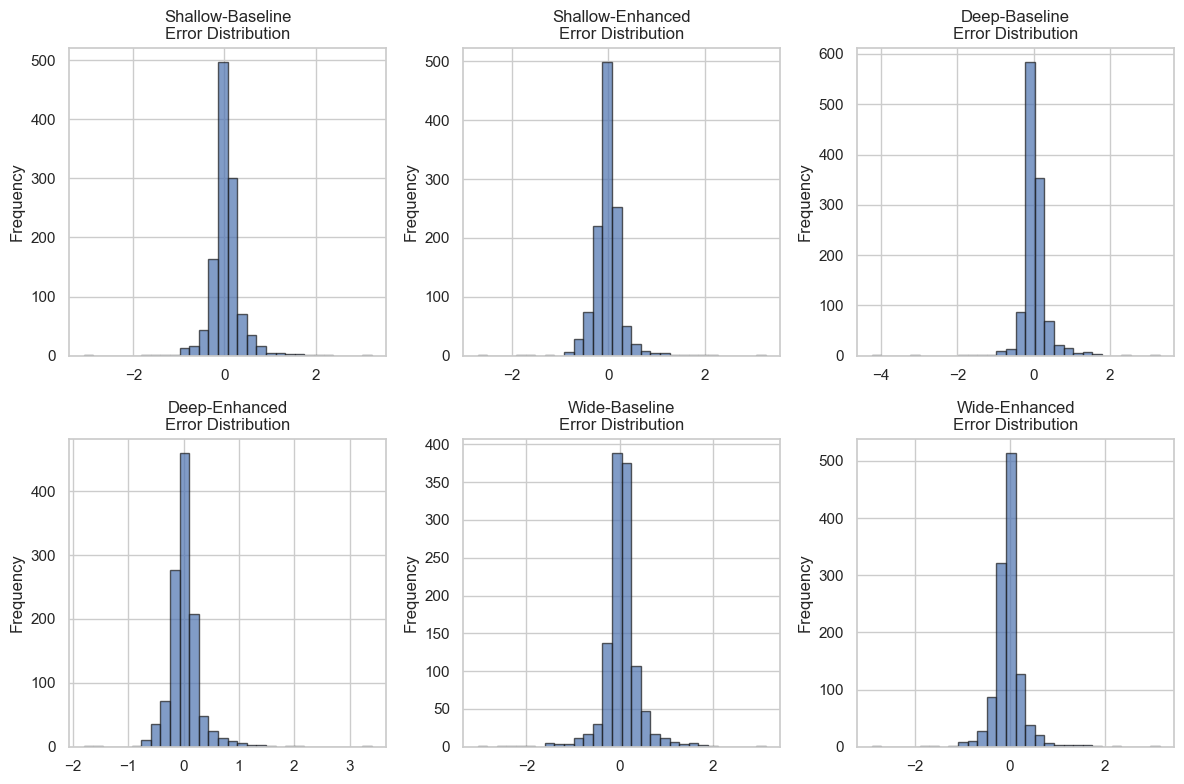

In [ ]:
#A function to get the predictions from NNs
def get_preds_mlps(model):
    model.eval()
    with torch.no_grad():
        preds = model(X_test).numpy()
    return preds

#To store predictions
nn_with_preds = {}

#For each model get the predictions
for nn in nn_trained_models:
    nn_with_preds[nn["Model"]] = get_preds_mlps(nn["model_obj"])


#plotting error distribution
y_true = np.array(testY).reshape(-1)
# plot error distributions
plt.figure(figsize=(12, 8))

for i, (model_name, y_pred) in enumerate(nn_with_preds.items(), 1):
    errors = y_true - y_pred.reshape(-1)
    plt.subplot(2, 3, i)
    plt.hist(errors, bins=30, edgecolor="k", alpha=0.7)
    plt.title(f"{model_name}\nError Distribution")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

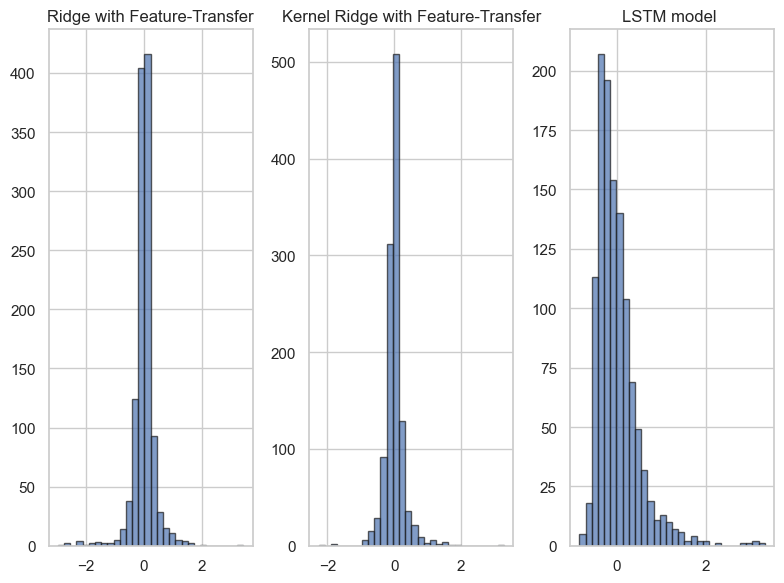

In [ ]:
#For ridge and kernel ridge with feature-transfer  and LSTM based model
plt.figure(figsize=(8, 6))
ridge_error = y_true - ridge_preds.reshape(-1)
krr_error = y_true - krr_preds.reshape(-1)
lstm_error = y_true[10:] - lstm_preds.reshape(-1)  #10 shift  as it has window size of 10
plt.subplot(1,3,1)
plt.hist(ridge_error, bins=30, edgecolor="k", alpha=0.7)
plt.title("Ridge with Feature-Transfer")

plt.subplot(1,3,2)
plt.hist(krr_error, bins=30, edgecolor="k", alpha=0.7)
plt.title("Kernel Ridge with Feature-Transfer")

plt.subplot(1,3,3)
plt.hist(lstm_error, bins=30, edgecolor="k", alpha=0.7)
plt.title("LSTM model ")
plt.tight_layout()
plt.show()



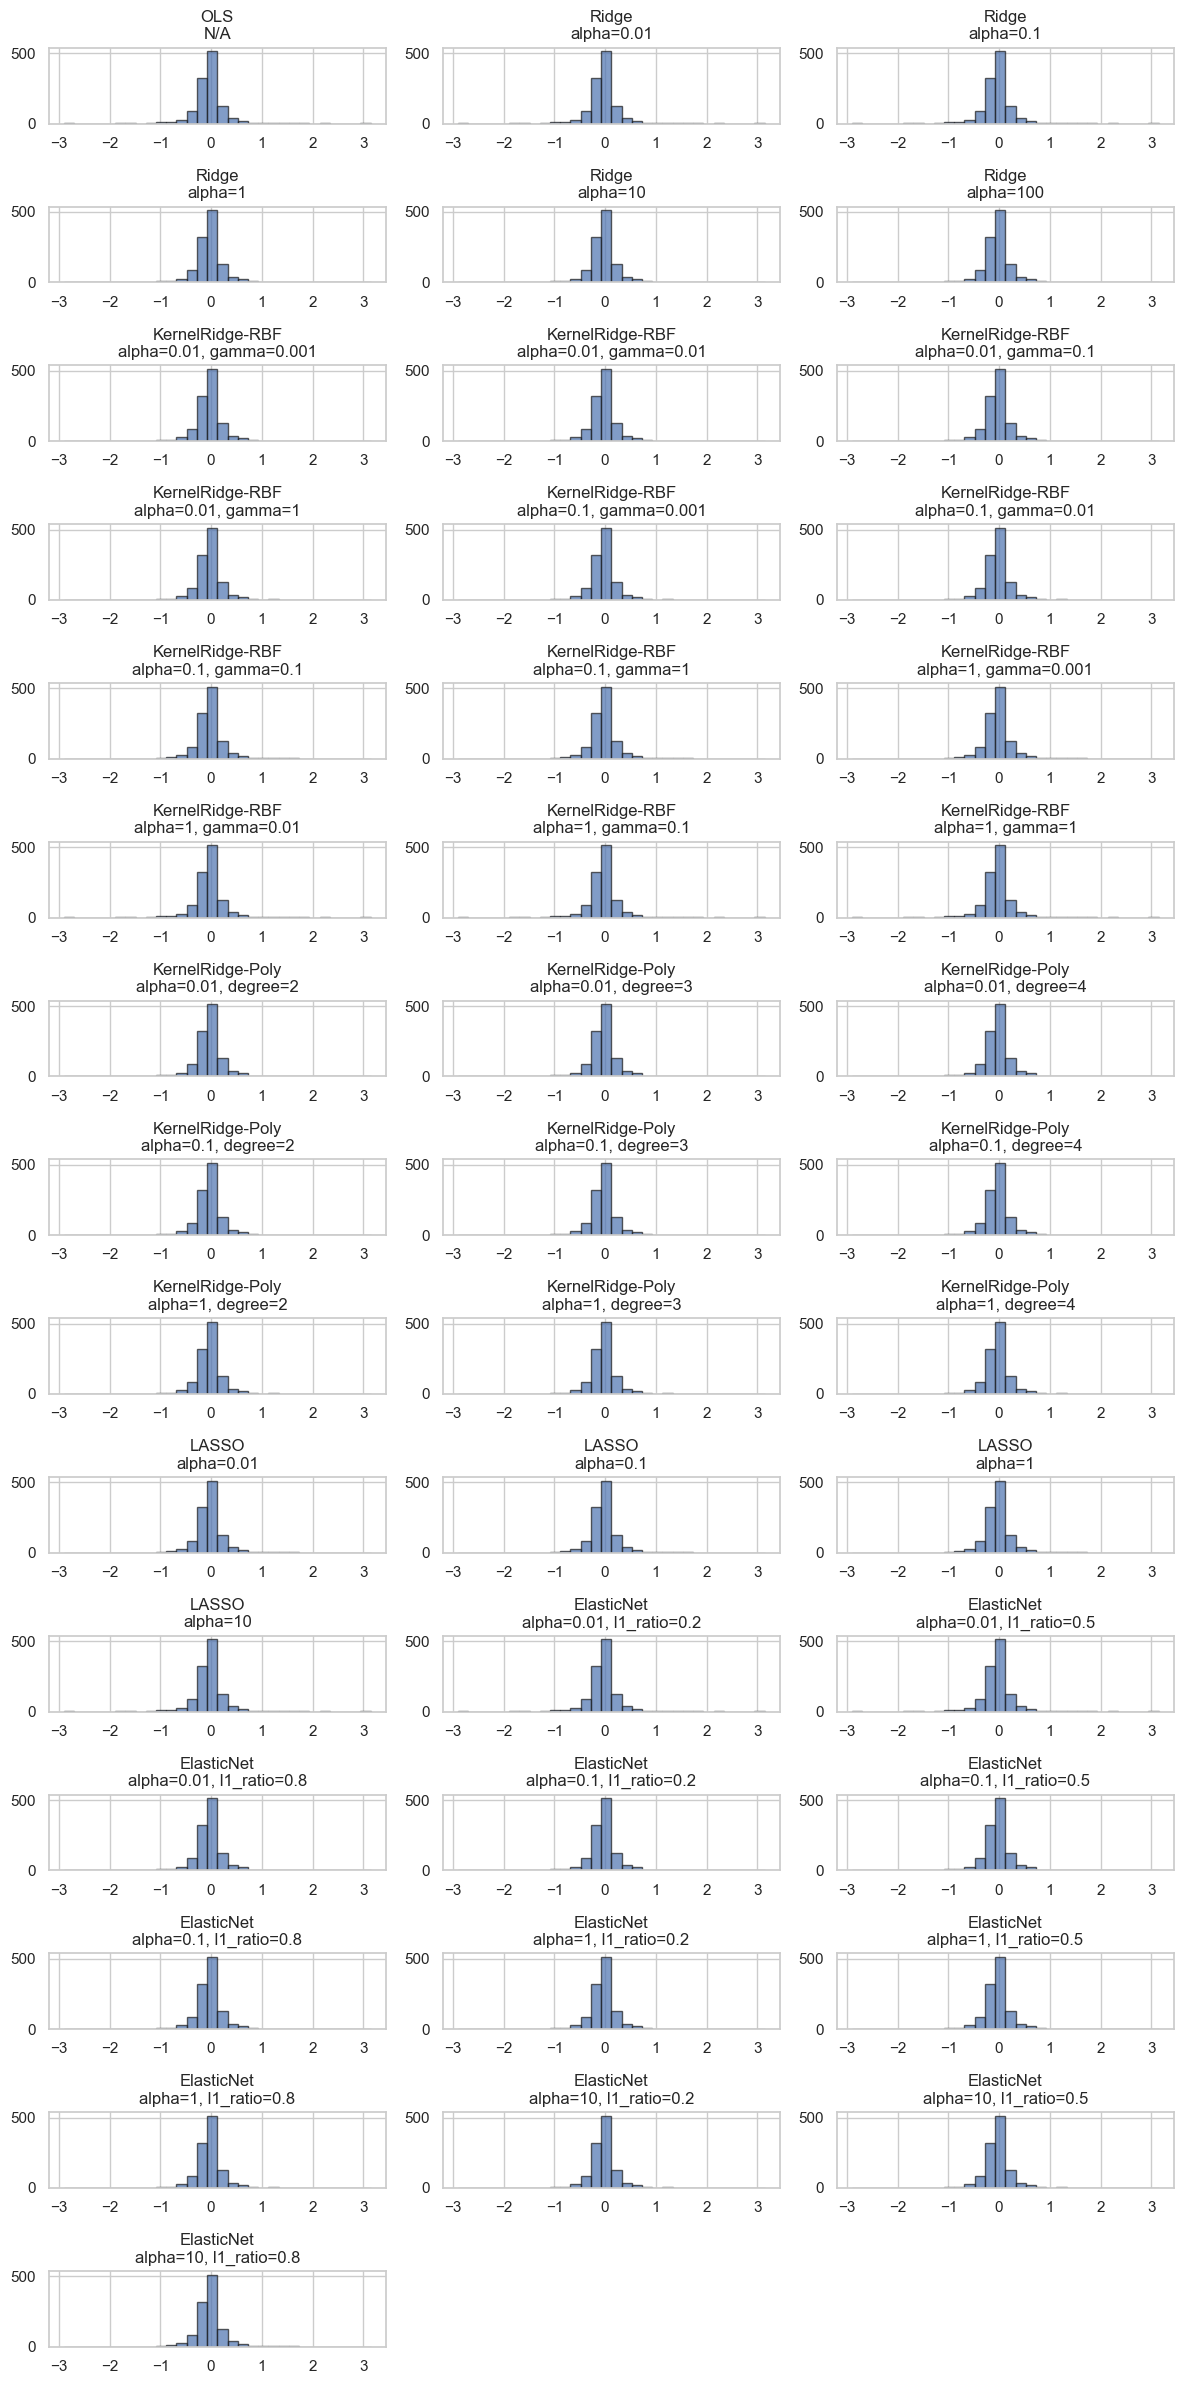

In [ ]:
ml_results = results_df[["Model","preds","Params"]]
plt.figure(figsize=(12, 24))
for i,row in ml_results.iterrows():
    model_name = row["Model"]
    preds = row["preds"]
    params = row["Params"]
    error = y_true - y_pred.reshape(-1)
    plt.subplot(15, 3, i+1)
    plt.hist(error, bins=30, edgecolor="k", alpha=0.7)
    plt.title(f"{model_name}\n{params}")

plt.tight_layout()
plt.show()

What was the single hardest bug or training issue you faced here (include error messages or plots)?

- Storing and plotting all the error-distribution histogram was hardest issue, it made us to rewrite some part of the code again.

What new insight did you gain about model behavior that no black-box solution could teach you?

- It shows us the error distribution of each model and it can help us, how each model perform to each other by looking out these histogram plots.

Hardest issue

The hardest issue came from handling outliers in numerical features like sqftliving, sqftbasement, sqftlot, and price. Extremely large properties and luxury houses created unreadable distributions and unstable training for models such as Ridge. Another challenge was dealing with the cardinality categorical columns like street and statezip which made the feature matrix sparse.

Insight about model behavior

We learned that linear models struggled with extreme values, but kernel methods captured nonlinear relationships between size and price effectively. Adding a batch normalization and custom activations in neural networks made training more stable which proved that architecture choices matter on tabular housing data. Overall, the experiments showed that cleaning outliers and engineering features mattered as much as choosing the right model.
